# SNe Ia and Hubble Diagram

## Residual dependence on host galaxy properties

### Load SN data.

In [1]:
import pickle
max_dist_arcsec = 1.0
with open("./post_data/valid_host_galaxies.pkl","rb") as f:
    data = pickle.load(f)

SN_sample = data["SN_sample"]
valid_SN_ids = data["valid_SN_ids"]
valid_host_galaxies = data["valid_host_galaxies"]
num_SN_samples = len(SN_sample)

In [2]:
import matplotlib.pyplot as plt

# Set global plotting font parameters
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 20,

    "axes.titlesize": 20,
    "axes.labelsize": 18,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "legend.fontsize": 20,

    "figure.titlesize": 20,
})

std_rc = plt.rcParams.copy()

### Cosmology Fitting

#### Cosmology models

In [3]:
import numpy as np
import scipy.constants as const
from scipy.integrate import quad


def E_Flat_LCDM(z, Omega_m):
    """Flat ΛCDM: E(z) function."""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m))


def E_Open_LCDM(z, Omega_m, Omega_k):
    """Open ΛCDM: E(z) function."""
    Omega_Lambda = 1 - Omega_m - Omega_k
    return np.sqrt(Omega_m * (1 + z) ** 3 + Omega_k * (1 + z) ** 2 + Omega_Lambda)


def E_Flat_wCDM(z, Omega_m, w):
    """Flat wCDM: E(z) function."""
    return np.sqrt(Omega_m * (1 + z) ** 3 + (1 - Omega_m) * (1 + z) ** (3 * (1 + w)))


def E_Flat_w0waCDM(z, Omega_m, w0, wa):
    """
    Flat w0waCDM: E(z) function. Using CPL paramerization: w(z) = w0 + wa * z/(1+z).
    """
    Omega_DE = 1 - Omega_m
    return np.sqrt(
        Omega_m * (1 + z) ** 3
        + Omega_DE * (1 + z) ** (3 * (1 + w0 + wa)) * np.exp(-3 * wa * z / (1 + z))
    )


def luminosity_distance_Flat_LCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat ΛCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m = params[0]
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_LCDM(z_prime, Omega_m)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Open_LCDM(z, params, H0=70.0):
    """
    Distance Modulus for Open ΛCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                Omega_k: Curvature density parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, Omega_k = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Open_LCDM(z_prime, Omega_m, Omega_k)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)
    dC *= dH

    # Comoving transverse distance
    if Omega_k == 0:
        dM = dC
    elif Omega_k > 0:
        dM = dH / np.sqrt(Omega_k) * np.sinh(np.sqrt(Omega_k) * dC / dH)  # 开放
    else:
        dM = dH / np.sqrt(-Omega_k) * np.sin(np.sqrt(-Omega_k) * dC / dH)  # 闭合

    return (1 + z) * dM


def luminosity_distance_Flat_wCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat wCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                w: Dark energy equation of state parameter
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, w = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_wCDM(z_prime, Omega_m, w)

    # Processing scalar and array inputs
    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def luminosity_distance_Flat_w0waCDM(z, params, H0=70.0):
    """
    Distance Modulus for Flat w0waCDM model.

    Parameters:
        z: Redshift
        params: Omega_m: Matter density parameter
                w0: Dark energy equation of state parameter at z=0
                wa: Evolution parameter of dark energy equation of state
        H0: Hubble constant (km/s/Mpc)
    Returns:
        Luminosity Distance (Mpc)
    """
    Omega_m, w0, wa = params
    dH = const.c / 1000.0 / H0

    def integrand(z_prime):
        return 1.0 / E_Flat_w0waCDM(z_prime, Omega_m, w0, wa)

    if np.isscalar(z):
        dC, _ = quad(integrand, 0, z)
    else:
        dC = np.zeros_like(z)
        for i, zi in enumerate(z):
            dC[i], _ = quad(integrand, 0, zi)

    return (1 + z) * dC * dH


def distance_modulus(z, params, model="Flat_LCDM"):
    """
    Distance modulus for various cosmological models.

    Parameters:
        z: Redshift
        params: Model parameters (tuple)
        model: Cosmological model. Options: "Flat_LCDM", "Open_LCDM", "Flat_wCDM", "Flat_w0waCDM"
    Returns:
        Distance Modulus (mu)
    """
    model_funcs = {
        "Flat_LCDM": luminosity_distance_Flat_LCDM,
        "Open_LCDM": luminosity_distance_Open_LCDM,
        "Flat_wCDM": luminosity_distance_Flat_wCDM,
        "Flat_w0waCDM": luminosity_distance_Flat_w0waCDM,
    }

    if model not in model_funcs:
        raise ValueError(f"Invalid model: {model}. Valid models: {list(model_funcs.keys())}")

    dL = model_funcs[model](z, params, H0=70.0)

    return 5 * np.log10(dL / 10) + 25

#### Set up sampler

In [4]:
import logging, sys
logger = logging.getLogger("ultranest")
handler = logging.StreamHandler(sys.stdout)
handler.setLevel(logging.WARNING)
logger.addHandler(handler)
logger.setLevel(logging.WARNING)

In [5]:
from ultranest.integrator import ReactiveNestedSampler
from ultranest.utils import resample_equal
import scipy

# load data
z_data = SN_sample["zHD"].data
mu_data = SN_sample["MU"].data
flat_cov_total_inv = np.load("./data/STAT+SYS.npz")["cov"]
C_total_inv = np.zeros((num_SN_samples, num_SN_samples))
indices = np.triu_indices(num_SN_samples)  # indices of upper triangle
C_total_inv[indices] = flat_cov_total_inv
C_total_inv = C_total_inv + C_total_inv.T - np.diag(np.diag(C_total_inv))
C_total = np.linalg.inv(C_total_inv)

L = np.linalg.cholesky(C_total)  # precompute Cholesky decomposition (for fast likelihood computation)

def prior_transform(cube, param_ranges):
    """
    Transform the unit hypercube [0,1]^d into the physical parameter space
    Parameters: [Omega_m, M]  (M is the combined parameter of absolute magnitude and H0)
    """
    params = np.zeros_like(cube)
    for i in range(len(param_ranges)):
        params[i] = (
            cube[i] * (param_ranges[i][1] - param_ranges[i][0]) + param_ranges[i][0]
        )
    return params


def log_likelihood(params, model="Flat_LCDM"):
    """
    Log-likelihood function: -0.5 * chi^2
    """
    M = params[-1]

    # Compute the theoretical distance modulus
    # (M is the absolute magnitude term in μ = 5 log10(dL) + 25 + M)
    mu_theory = np.array(
        [distance_modulus(z, params[:-1], model=model) + M for z in z_data]
    )

    residuals = mu_data - mu_theory
    if np.any(np.isinf(residuals)) or np.any(np.isnan(residuals)):
        return -1.0e99 * (np.abs(M) + 1)

    y = scipy.linalg.solve_triangular(L, residuals, lower=True)
    chi2 = np.sum(y**2)

    return -0.5 * chi2

def fit_cosmology(cosmology_model="Flat_LCDM"):
    """
    Fit cosmological parameters using UltraNest

    Args:
        cosmology_model:
            'Flat_LCDM': FlatΛCDM
            'Open_LCDM': OpenΛCDM
            'Flat_wCDM': FlatwCDM
            'Flat_w0waCDM': Flatw0waCDM

    Returns:
        sampling result object
    """
    param_names = {
        "Flat_LCDM": [r"$\Omega_m$", "M"],
        "Open_LCDM": [r"$\Omega_m$", r"$\Omega_k$", "M"],
        "Flat_wCDM": [r"$\Omega_m$", r"$w$", "M"],
        "Flat_w0waCDM": [r"$\Omega_m$", r"$w_0$", r"$w_a$", "M"],
    }
    param_ranges = {
        "Flat_LCDM": [(0.25, 0.4), (-20, 10)],
        "Open_LCDM": [(0.1, 0.5), (-1, 1), (-20, 10)],
        "Flat_wCDM": [(0.1, 0.4), (-2, 0.5), (-20, 10)],
        "Flat_w0waCDM": [(0.0, 1.0), (-20, 10), (-20, 10), (-20, 10)],
    }

    sampler = ReactiveNestedSampler(
        param_names[cosmology_model],
        lambda params: log_likelihood(params, model=cosmology_model),
        lambda cube: prior_transform(cube, param_ranges[cosmology_model]),
    )

    result = sampler.run()
    return result

#### Fitting results

In [6]:
from getdist import MCSamples, plots
from ultranest.plot import cornerplot
import pickle
import os

def smooth_plot(result):
    samples = result['samples']  # (n_samples, n_params)
    weights = result['weighted_samples']['weights']

    # Exclude the last parameter
    param_names_all = result['paramnames']  # all parameter names

    # Create MCSamples object excluding the last parameter
    samples_mcd = MCSamples(
        samples=samples[:, :-1],  # Exclude the last column
        weights=weights,
        names=param_names_all[:-1],  # Exclude the last parameter name
        settings={'smooth_scale_2D': 0.8}  # Optional: smoothing parameter
    )

    # Plot the triangle plot
    g = plots.get_subplot_plotter()
    g.triangle_plot([samples_mcd], filled=True)

##### Flat LCDM

Corner plots

In [7]:
plt.rcParams.update({
    "font.family": "serif",
    "font.size": 12,

    "axes.titlesize": 12,
    "axes.labelsize": 12,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,

    "figure.titlesize": 12,
})

Removed no burn in


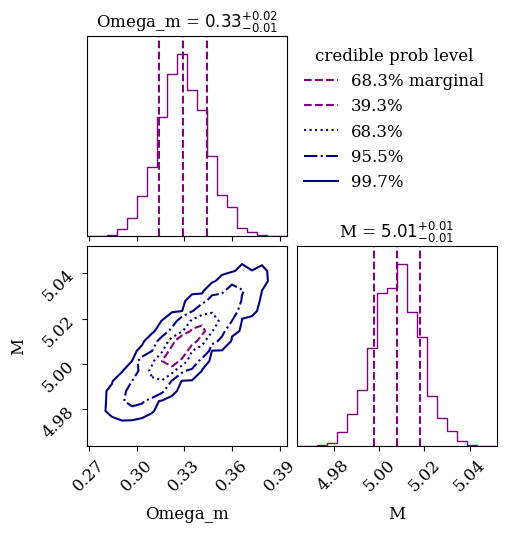

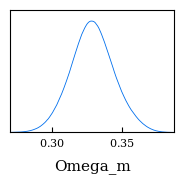

Omega_m = 0.3289 +0.0152 -0.0143
M       = 5.0081 +0.0099 -0.0103


In [8]:
fit_dir = 'fits'
os.makedirs(fit_dir, exist_ok=True)

with open(f'{fit_dir}/Flat_LCDM_wide_result.pkl', 'rb') as f:
    Flat_LCDM_result = pickle.load(f)

cornerplot(Flat_LCDM_result)
smooth_plot(Flat_LCDM_result)
plt.show()

# Extract weighted posterior
samples   = Flat_LCDM_result["weighted_samples"]["points"]
weights   = Flat_LCDM_result["weighted_samples"]["weights"]

# Resample to get equal-weighted posterior
equal_samples = resample_equal(samples, weights / np.sum(weights))

# compute median and 16/84 percentiles
Omega_m_q16, Omega_m_q50, Omega_m_q84 = np.percentile(equal_samples[:, 0], [16, 50, 84])
M_q16,       M_q50,       M_q84       = np.percentile(equal_samples[:, 1], [16, 50, 84])

print(f"Omega_m = {Omega_m_q50:.4f} +{Omega_m_q84 - Omega_m_q50:.4f} "
      f"-{Omega_m_q50 - Omega_m_q16:.4f}")
print(f"M       = {M_q50:.4f} +{M_q84 - M_q50:.4f} "
      f"-{M_q50 - M_q16:.4f}")

In [9]:
plt.rcParams.update(std_rc)

#### Pearson Test

In [10]:
import numpy as np
from scipy import stats

def pearson_test(x, y):
    # 计算皮尔逊相关系数和p值
    pearson_r, pearson_p = stats.pearsonr(x, y)

    print("\n=== Pearson Correlation Test ===")
    print(f"Pearson correlation coefficient (r) = {pearson_r:.4f}")
    print(f"p-value = {pearson_p:.4e}")

    # 解释相关系数的强度
    def interpret_correlation(r):
        abs_r = abs(r)
        if abs_r >= 0.8:
            return "very strong"
        elif abs_r >= 0.6:
            return "strong"
        elif abs_r >= 0.4:
            return "moderate"
        elif abs_r >= 0.2:
            return "weak"
        else:
            return "very weak or none"

    strength = interpret_correlation(pearson_r)
    print(f"Correlation strength: {strength}")

    # 检查统计显著性
    alpha = 0.05  # 显著性水平
    if pearson_p < alpha:
        print(f"Correlation is statistically significant at α={alpha} level")
    else:
        print(f"Correlation is NOT statistically significant at α={alpha} level")

### Mass Step

#### Using Flat-LCDM no analytical marginalization over M

Linear trend: Δμ = (-0.0329) × Log Mass + (0.3848)
Mean Δμ for Log Mass < 10: 0.0671
Mean Δμ for Log Mass >= 10: 0.0386


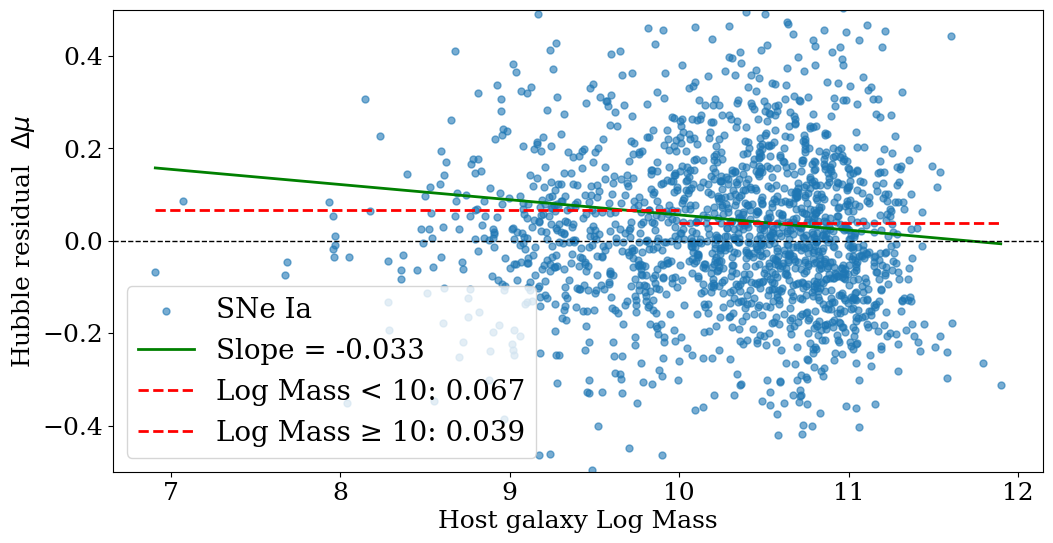


=== Pearson Correlation Test ===
Pearson correlation coefficient (r) = -0.0907
p-value = 1.0643e-04
Correlation strength: very weak or none
Correlation is statistically significant at α=0.05 level


In [11]:
def mass_step_flat_LCDM_no_marg():
    global residual_mass
    residual_mass = SN_sample["MU"] - np.array(
        [distance_modulus(z, [Omega_m_q50], model="Flat_LCDM") + M_q50 for z in z_data]
    )
    host_mass = SN_sample["HOSTGAL_LOGMASS"]

    coef_mass = np.polyfit(host_mass, residual_mass, 1)
    slope_mass, intercept_mass = coef_mass

    xfit_mass = np.linspace(host_mass.min(), host_mass.max(), 200)
    yfit_mass = slope_mass * xfit_mass + intercept_mass

    print(f"Linear trend: Δμ = ({slope_mass:.4f}) × Log Mass + ({intercept_mass:.4f})")

    plt.figure(figsize=(12, 6))
    plt.scatter(host_mass, residual_mass, s=25, alpha=0.6, label="SNe Ia")
    plt.plot(xfit_mass, yfit_mass, color="green", lw=2, label=f"Slope = {slope_mass:.3f}")

    # 计算两个质量区间的平均值
    mask_low_mass = host_mass < 10
    mask_high_mass = host_mass >= 10

    mean_low_mass = np.mean(residual_mass[mask_low_mass])
    mean_high_mass = np.mean(residual_mass[mask_high_mass])

    print(f"Mean Δμ for Log Mass < 10: {mean_low_mass:.4f}")
    print(f"Mean Δμ for Log Mass >= 10: {mean_high_mass:.4f}")

    # 添加两条平均线
    # 另一种方式：使用不同的线条样式
    plt.plot([np.min(host_mass), 10], [mean_low_mass, mean_low_mass], 
            color='r', ls='--', lw=2, 
            label=f'Log Mass < 10: {mean_low_mass:.3f}')

    plt.plot([10, np.max(host_mass)], [mean_high_mass, mean_high_mass], 
            color='r', ls='--', lw=2, 
            label=f'Log Mass ≥ 10: {mean_high_mass:.3f}')

    plt.axhline(0.0, color="k", ls="--", lw=1)
    plt.xlabel("Host galaxy Log Mass")
    plt.ylabel(r"Hubble residual  $\Delta\mu$")
    plt.ylim(-0.5, 0.5)
    plt.legend()
    plt.show()

    pearson_test(host_mass, residual_mass)

mass_step_flat_LCDM_no_marg()

##### Trying to add mass step correction

Linear trend: Δμ = (-0.0151) × Log Mass + (0.2085)
Mean Δμ for Log Mass < 10: 0.0506
Mean Δμ for Log Mass >= 10: 0.0551

=== Pearson Correlation Test ===
Pearson correlation coefficient (r) = -0.0417
p-value = 7.4973e-02
Correlation strength: very weak or none
Correlation is NOT statistically significant at α=0.05 level


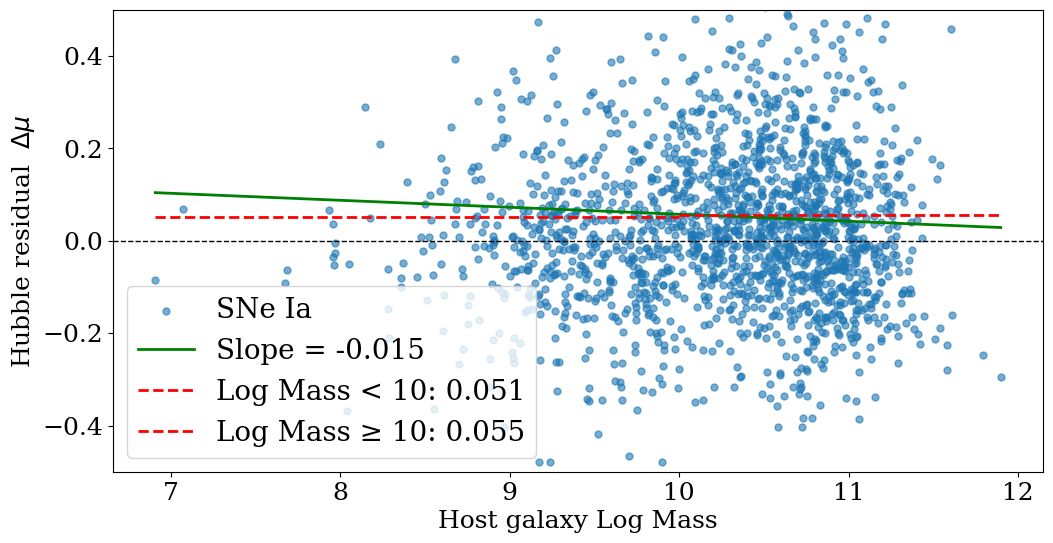

In [12]:
def mass_step_flat_LCDM_no_marg_correction():
    global host_mass
    host_mass = SN_sample["HOSTGAL_LOGMASS"]
    gamma = 0.033
    # # Another correction method
    # gamma = 0.033
    # tau = 0.1 # 文章没给
    # mu_mass_corrected = (
    #     SN_sample["MU"] - gamma * (1 + np.exp((host_mass - 10) / tau)) ** (-1) - 0.5 * gamma
    # )
    global mu_mass_corrected
    mu_mass_corrected = SN_sample["MU"] + gamma / 2 * np.where(host_mass >= 10, 1, -1)
    residual_mass_corrected = mu_mass_corrected - np.array(
        [distance_modulus(z, [Omega_m_q50], model="Flat_LCDM") + M_q50 for z in z_data]
    )

    coef_mass_corrected = np.polyfit(host_mass, residual_mass_corrected, 1)
    slope_mass_corrected, intercept_mass_corrected = coef_mass_corrected

    xfit_mass_corrected = np.linspace(host_mass.min(), host_mass.max(), 200)
    yfit_mass_corrected = (
        slope_mass_corrected * xfit_mass_corrected + intercept_mass_corrected
    )

    print(
        f"Linear trend: Δμ = ({slope_mass_corrected:.4f}) × Log Mass + ({intercept_mass_corrected:.4f})"
    )

    plt.figure(figsize=(12, 6))
    plt.scatter(host_mass, residual_mass_corrected, s=25, alpha=0.6, label="SNe Ia")
    plt.plot(
        xfit_mass_corrected,
        yfit_mass_corrected,
        color="green",
        lw=2,
        label=f"Slope = {slope_mass_corrected:.3f}",
    )

    # 计算两个质量区间的平均值
    mask_low_mass_corrected = host_mass < 10
    mask_high_mass_corrected = host_mass >= 10

    mean_low_mass_corrected = np.mean(residual_mass_corrected[mask_low_mass_corrected])
    mean_high_mass_corrected = np.mean(residual_mass_corrected[mask_high_mass_corrected])

    print(f"Mean Δμ for Log Mass < 10: {mean_low_mass_corrected:.4f}")
    print(f"Mean Δμ for Log Mass >= 10: {mean_high_mass_corrected:.4f}")

    plt.plot(
        [np.min(host_mass), 10],
        [mean_low_mass_corrected, mean_low_mass_corrected],
        color="r",
        ls="--",
        lw=2,
        label=f"Log Mass < 10: {mean_low_mass_corrected:.3f}",
    )

    plt.plot(
        [10, np.max(host_mass)],
        [mean_high_mass_corrected, mean_high_mass_corrected],
        color="r",
        ls="--",
        lw=2,
        label=f"Log Mass ≥ 10: {mean_high_mass_corrected:.3f}",
    )

    plt.axhline(0.0, color="k", ls="--", lw=1)
    plt.xlabel("Host galaxy Log Mass")
    plt.ylabel(r"Hubble residual  $\Delta\mu$")
    plt.ylim(-0.5, 0.5)
    plt.legend()

    pearson_test(host_mass, residual_mass_corrected)
    plt.show()

mass_step_flat_LCDM_no_marg_correction()

In [13]:
def log_likelihood_W1(params):
    """
    Log-likelihood function: -0.5 * chi^2
    """
    M = params[-1]

    # Compute the theoretical distance modulus
    # (M is the absolute magnitude term in μ = 5 log10(dL/10) + 25 + M)
    mu_theory = np.array(
        [distance_modulus(z, params[:1], model="Flat_LCDM") + M for z in z_data]
    )

    residuals = mu_mass_corrected-0.04 - mu_theory
    if np.any(np.isinf(residuals)) or np.any(np.isnan(residuals)):
        return -1.0e99 * (np.abs(M) + 1)

    y = scipy.linalg.solve_triangular(L, residuals, lower=True)
    chi2 = np.sum(y**2)

    return -0.5 * chi2


param_names = [r"$\Omega_m$", "M"]
param_ranges = [(0.25, 0.4), (-20, 10)]
sampler = ReactiveNestedSampler(
    param_names,
    lambda params: log_likelihood(params, model="Flat_LCDM"),
    lambda cube: prior_transform(cube, param_ranges),
)

Flat_LCDM_with_mass_corrected_result = sampler.run()

Linear trend: Δμ = (-0.0151) × W1 + (0.2090)
Mean Δμ for Log Mass < 10: 0.0512
Mean Δμ for Log Mass >= 10: 0.0557


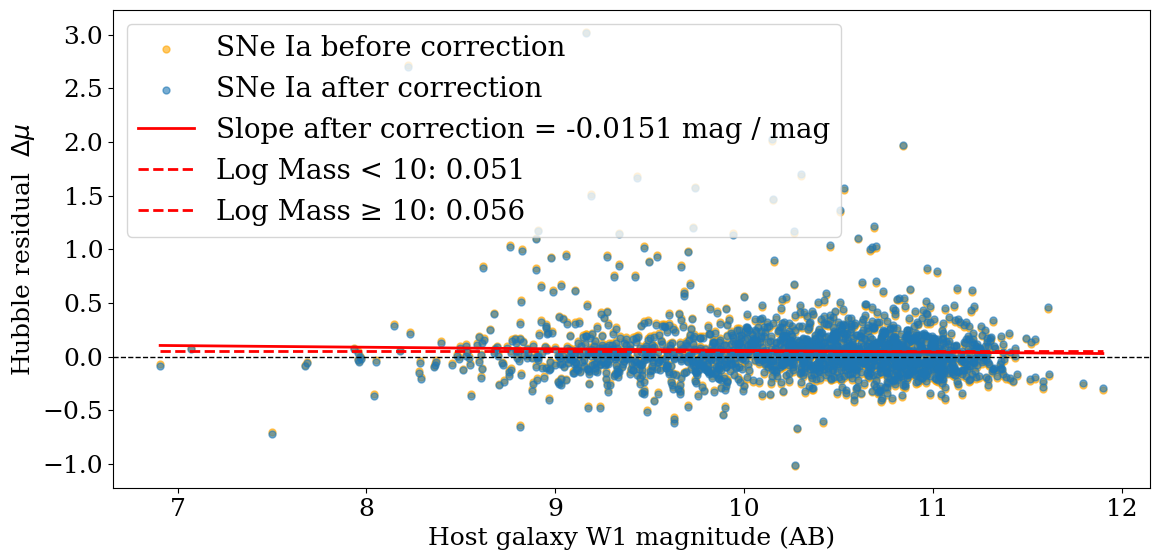

In [14]:
# Extract weighted posterior
samples   = Flat_LCDM_with_mass_corrected_result["weighted_samples"]["points"]
weights   = Flat_LCDM_with_mass_corrected_result["weighted_samples"]["weights"]

# Resample to get equal-weighted posterior
equal_samples = resample_equal(samples, weights / np.sum(weights))

# compute median and 16/84 percentiles
Omega_m_q16_corrected, Omega_m_q50_corrected, Omega_m_q84_corrected = np.percentile(equal_samples[:, 0], [16, 50, 84])
M_q16_corrected,       M_q50_corrected,       M_q84_corrected       = np.percentile(equal_samples[:, 1], [16, 50, 84])

# Model distance modulus for Flat ΛCDM
mu_model_corrected = np.array(
    [distance_modulus(z, [Omega_m_q50_corrected], model="Flat_LCDM") + M_q50_corrected for z in z_data]
)

# Hubble residuals after iteration: Δμ = μ_obs − μ_model
residuals_mass_corrected = mu_mass_corrected - mu_model_corrected

coef = np.polyfit(host_mass, residuals_mass_corrected, 1)
slope, intercept = coef

xfit = np.linspace(host_mass.min(), host_mass.max(), 200)
yfit = slope * xfit + intercept

print(f"Linear trend: Δμ = ({slope:.4f}) × W1 + ({intercept:.4f})")

plt.figure(figsize=(12, 6))
plt.scatter(host_mass, residual_mass, s=25, alpha=0.6, label="SNe Ia before correction", c='orange')
plt.scatter(host_mass, residuals_mass_corrected, s=25, alpha=0.6, label="SNe Ia after correction")
plt.plot(xfit, yfit, color="r", lw=2, label=f"Slope after correction = {slope:.4f} mag / mag")

# 计算两个质量区间的平均值
mask_low_mass = host_mass < 10
mask_high_mass = host_mass >= 10

mean_low_mass = np.mean(residuals_mass_corrected[mask_low_mass])
mean_high_mass = np.mean(residuals_mass_corrected[mask_high_mass])

print(f"Mean Δμ for Log Mass < 10: {mean_low_mass:.4f}")
print(f"Mean Δμ for Log Mass >= 10: {mean_high_mass:.4f}")

# 添加两条平均线
# 另一种方式：使用不同的线条样式
plt.plot([np.min(host_mass), 10], [mean_low_mass, mean_low_mass], 
        color='r', ls='--', lw=2, 
        label=f'Log Mass < 10: {mean_low_mass:.3f}')

plt.plot([10, np.max(host_mass)], [mean_high_mass, mean_high_mass], 
        color='r', ls='--', lw=2, 
        label=f'Log Mass ≥ 10: {mean_high_mass:.3f}')


plt.axhline(0.0, color="k", ls="--", lw=1)
plt.xlabel("Host galaxy W1 magnitude (AB)")
plt.ylabel(r"Hubble residual  $\Delta\mu$")
plt.legend()
plt.tight_layout()
plt.show()

**CMT**: Why M didn't absorb the overall deviation $\sim 0.05$?

### Check Other Cosmological Models

#### Using Flat-LCDM with analytical marginalization over M

Omega_m = 0.3289 +0.0152 -0.0142
Linear trend: Δμ = (-0.0329) × Log Mass + (0.3853)
Mean Δμ for Log Mass < 10: 0.0676
Mean Δμ for Log Mass >= 10: 0.0390


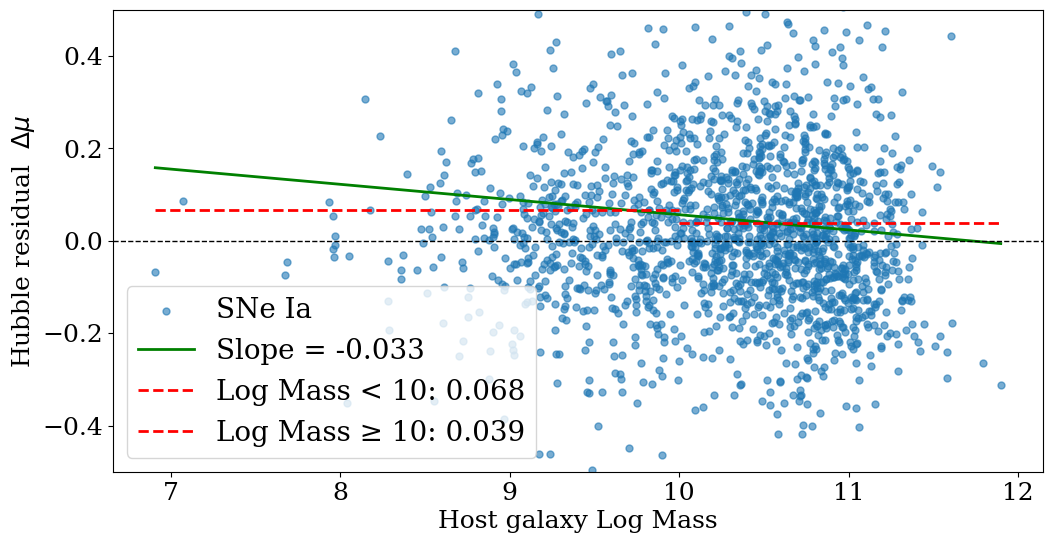


=== Pearson Correlation Test ===
Pearson correlation coefficient (r) = -0.0907
p-value = 1.0619e-04
Correlation strength: very weak or none
Correlation is statistically significant at α=0.05 level


In [15]:
def mass_step_flat_LCDM_with_marg():
    with open(f"{fit_dir}/Flat_LCDM_wide_result.pkl", "rb") as f:
        Flat_LCDM_result = pickle.load(f)

    # Extract weighted posterior
    samples = Flat_LCDM_result["weighted_samples"]["points"]
    weights = Flat_LCDM_result["weighted_samples"]["weights"]

    # Resample to get equal-weighted posterior
    equal_samples = resample_equal(samples, weights / np.sum(weights))

    # compute median and 16/84 percentiles
    Omega_m_q16, Omega_m_q50, Omega_m_q84 = np.percentile(equal_samples[:, 0], [16, 50, 84])

    def estimate_M_best_fit(params_best, z_data, mu_data, inv_cov, model="Flat_LCDM"):
        """
        在最佳拟合参数下估计M的值。
        
        Parameters:
        -----------
        params_best : array
            最佳拟合宇宙学参数
        z_data : array
            红移数据
        mu_data : array
            观测距离模数
        inv_cov : array
            逆协方差矩阵
        
        Returns:
        --------
        M_best : float
            M的最佳估计值
        M_uncertainty : float
            M的不确定度
        """
        # 计算理论预测（不含M）
        mu_pred = np.array([distance_modulus(z, params_best, model=model) for z in z_data])
        
        # 计算残差
        residuals = mu_data - mu_pred  # μ_obs - μ_pred
        
        # 计算 B = 1^T C^{-1} residuals
        ones = np.ones_like(residuals)
        B = ones @ inv_cov @ residuals
        
        # 计算 C = 1^T C^{-1} 1
        C = ones @ inv_cov @ ones
        
        # 最佳M值
        M_best = B / C
        
        # M的不确定度：σ_M = 1/√C
        M_uncertainty = 1.0 / np.sqrt(C)
        
        return M_best, M_uncertainty

    print(
        f"Omega_m = {Omega_m_q50:.4f} +{Omega_m_q84 - Omega_m_q50:.4f} "
        f"-{Omega_m_q50 - Omega_m_q16:.4f}"
    )

    residual_mass = SN_sample["MU"] - np.array(
        [
            distance_modulus(z, [Omega_m_q50], model="Flat_LCDM") + estimate_M_best_fit([Omega_m_q50], z_data, SN_sample["MU"], C_total_inv, model="Flat_LCDM")[0]
            for z in z_data
        ]
    )
    host_mass = SN_sample["HOSTGAL_LOGMASS"]

    coef_mass = np.polyfit(host_mass, residual_mass, 1)
    slope_mass, intercept_mass = coef_mass

    xfit_mass = np.linspace(host_mass.min(), host_mass.max(), 200)
    yfit_mass = slope_mass * xfit_mass + intercept_mass

    print(f"Linear trend: Δμ = ({slope_mass:.4f}) × Log Mass + ({intercept_mass:.4f})")

    plt.figure(figsize=(12, 6))
    plt.scatter(host_mass, residual_mass, s=25, alpha=0.6, label="SNe Ia")
    plt.plot(xfit_mass, yfit_mass, color="green", lw=2, label=f"Slope = {slope_mass:.3f}")

    # 计算两个质量区间的平均值
    mask_low_mass = host_mass < 10
    mask_high_mass = host_mass >= 10

    mean_low_mass = np.mean(residual_mass[mask_low_mass])
    mean_high_mass = np.mean(residual_mass[mask_high_mass])

    print(f"Mean Δμ for Log Mass < 10: {mean_low_mass:.4f}")
    print(f"Mean Δμ for Log Mass >= 10: {mean_high_mass:.4f}")

    # 添加两条平均线
    # 另一种方式：使用不同的线条样式
    plt.plot(
        [np.min(host_mass), 10],
        [mean_low_mass, mean_low_mass],
        color="r",
        ls="--",
        lw=2,
        label=f"Log Mass < 10: {mean_low_mass:.3f}",
    )

    plt.plot(
        [10, np.max(host_mass)],
        [mean_high_mass, mean_high_mass],
        color="r",
        ls="--",
        lw=2,
        label=f"Log Mass ≥ 10: {mean_high_mass:.3f}",
    )

    plt.axhline(0.0, color="k", ls="--", lw=1)
    plt.xlabel("Host galaxy Log Mass")
    plt.ylabel(r"Hubble residual  $\Delta\mu$")
    plt.ylim(-0.5, 0.5)
    plt.legend()
    plt.show()

    pearson_test(host_mass, residual_mass)

mass_step_flat_LCDM_with_marg()

#### Using Flat-w0waCDM no analytical marginalization over M

Omega_m = 0.4721 +0.0352 -0.0482
Linear trend: Δμ = (-0.0335) × Log Mass + (0.3907)
Mean Δμ for Log Mass < 10: 0.0672
Mean Δμ for Log Mass >= 10: 0.0379


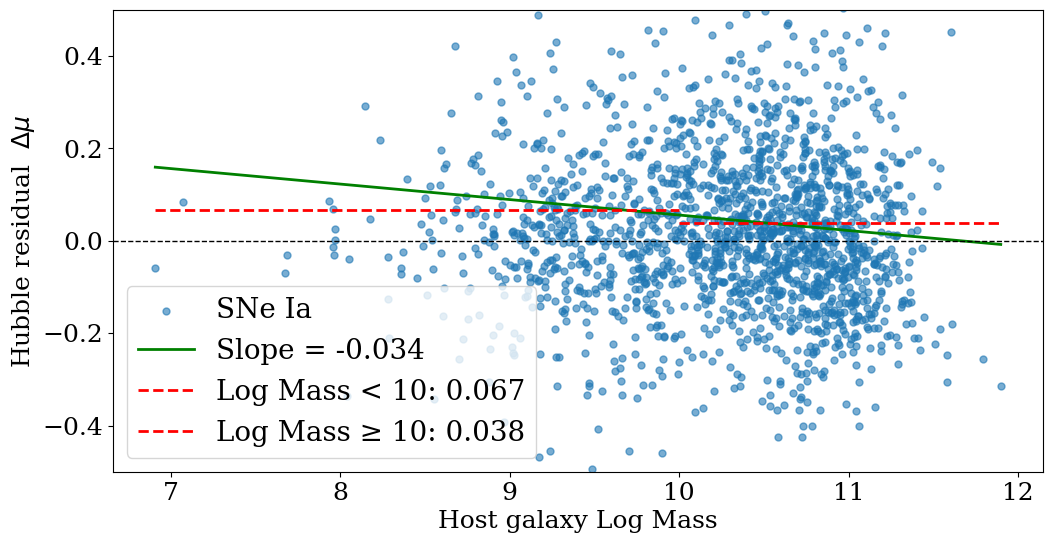

In [16]:
def mass_step_flat_w0waCDM_no_marg():
    with open(f"{fit_dir}/Flat_w0waCDM_wide_result.pkl", "rb") as f:
        Flat_w0waCDM_result = pickle.load(f)

    # Extract weighted posterior
    samples = Flat_w0waCDM_result["weighted_samples"]["points"]
    weights = Flat_w0waCDM_result["weighted_samples"]["weights"]

    # Resample to get equal-weighted posterior
    equal_samples = resample_equal(samples, weights / np.sum(weights))

    # compute median and 16/84 percentiles
    Omega_m_q16, Omega_m_q50, Omega_m_q84 = np.percentile(equal_samples[:, 0], [16, 50, 84])
    w0_q16, w0_q50, w0_q84 = np.percentile(equal_samples[:, 1], [16, 50, 84])
    wa_q16, wa_q50, wa_q84 = np.percentile(equal_samples[:, 2], [16, 50, 84])
    Ma_q16, Ma_q50, Ma_q84 = np.percentile(equal_samples[:, 3], [16, 50, 84])

    print(
        f"Omega_m = {Omega_m_q50:.4f} +{Omega_m_q84 - Omega_m_q50:.4f} "
        f"-{Omega_m_q50 - Omega_m_q16:.4f}"
    )

    residual_mass = SN_sample["MU"] - np.array(
        [
            distance_modulus(z, [Omega_m_q50, w0_q50, wa_q50], model="Flat_w0waCDM") + Ma_q50
            for z in z_data
        ]
    )
    host_mass = SN_sample["HOSTGAL_LOGMASS"]

    coef_mass = np.polyfit(host_mass, residual_mass, 1)
    slope_mass, intercept_mass = coef_mass

    xfit_mass = np.linspace(host_mass.min(), host_mass.max(), 200)
    yfit_mass = slope_mass * xfit_mass + intercept_mass

    print(f"Linear trend: Δμ = ({slope_mass:.4f}) × Log Mass + ({intercept_mass:.4f})")

    plt.figure(figsize=(12, 6))
    plt.scatter(host_mass, residual_mass, s=25, alpha=0.6, label="SNe Ia")
    plt.plot(xfit_mass, yfit_mass, color="green", lw=2, label=f"Slope = {slope_mass:.3f}")

    # 计算两个质量区间的平均值
    mask_low_mass = host_mass < 10
    mask_high_mass = host_mass >= 10

    mean_low_mass = np.mean(residual_mass[mask_low_mass])
    mean_high_mass = np.mean(residual_mass[mask_high_mass])

    print(f"Mean Δμ for Log Mass < 10: {mean_low_mass:.4f}")
    print(f"Mean Δμ for Log Mass >= 10: {mean_high_mass:.4f}")

    # 添加两条平均线
    # 另一种方式：使用不同的线条样式
    plt.plot(
        [np.min(host_mass), 10],
        [mean_low_mass, mean_low_mass],
        color="r",
        ls="--",
        lw=2,
        label=f"Log Mass < 10: {mean_low_mass:.3f}",
    )

    plt.plot(
        [10, np.max(host_mass)],
        [mean_high_mass, mean_high_mass],
        color="r",
        ls="--",
        lw=2,
        label=f"Log Mass ≥ 10: {mean_high_mass:.3f}",
    )

    plt.axhline(0.0, color="k", ls="--", lw=1)
    plt.xlabel("Host galaxy Log Mass")
    plt.ylabel(r"Hubble residual  $\Delta\mu$")
    plt.ylim(-0.5, 0.5)
    plt.legend()
    plt.show()

mass_step_flat_w0waCDM_no_marg()

#### Using Flat-w0waCDM with analytical marginalization over M

Omega_m = 0.4722 +0.0359 -0.0494
Linear trend: Δμ = (-0.0336) × Log Mass + (0.3919)
Mean Δμ for Log Mass < 10: 0.0680
Mean Δμ for Log Mass >= 10: 0.0386


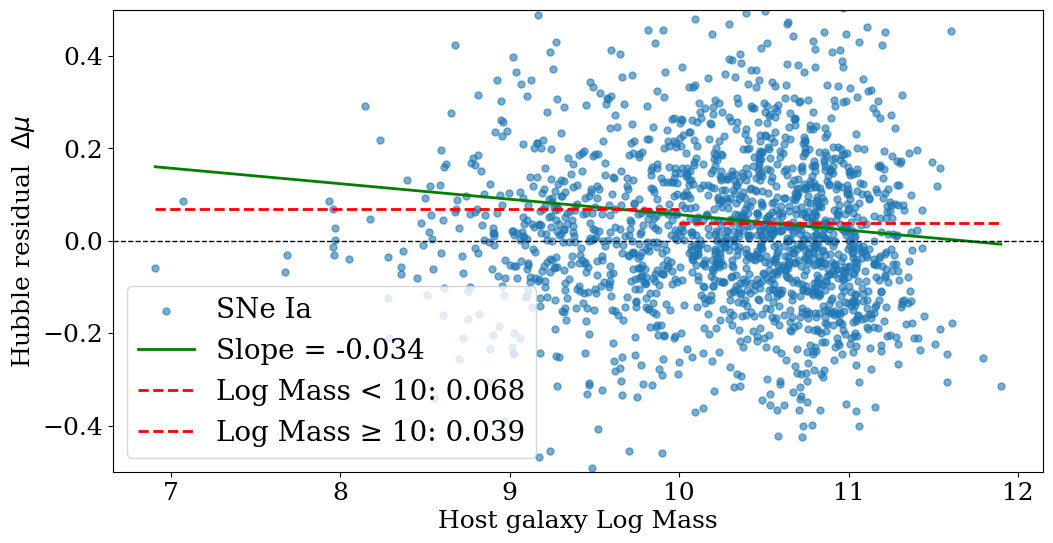


=== Pearson Correlation Test ===
Pearson correlation coefficient (r) = -0.0923
p-value = 8.0670e-05
Correlation strength: very weak or none
Correlation is statistically significant at α=0.05 level


In [17]:
def mass_step_flat_w0waCDM_with_marg():
    with open(f"{fit_dir}/Flat_w0waCDM_wide_marg_result.pkl", "rb") as f:
        Flat_w0waCDM_result = pickle.load(f)

    # Extract weighted posterior
    samples = Flat_w0waCDM_result["weighted_samples"]["points"]
    weights = Flat_w0waCDM_result["weighted_samples"]["weights"]

    # Resample to get equal-weighted posterior
    equal_samples = resample_equal(samples, weights / np.sum(weights))

    # compute median and 16/84 percentiles
    Omega_m_q16, Omega_m_q50, Omega_m_q84 = np.percentile(equal_samples[:, 0], [16, 50, 84])
    w0_q16, w0_q50, w0_q84 = np.percentile(equal_samples[:, 1], [16, 50, 84])
    wa_q16, wa_q50, wa_q84 = np.percentile(equal_samples[:, 2], [16, 50, 84])

    def estimate_M_best_fit(params_best, z_data, mu_data, inv_cov, model="Flat_LCDM"):
        """
        在最佳拟合参数下估计M的值。
        
        Parameters:
        -----------
        params_best : array
            最佳拟合宇宙学参数
        z_data : array
            红移数据
        mu_data : array
            观测距离模数
        inv_cov : array
            逆协方差矩阵
        
        Returns:
        --------
        M_best : float
            M的最佳估计值
        M_uncertainty : float
            M的不确定度
        """
        # 计算理论预测（不含M）
        mu_pred = np.array([distance_modulus(z, params_best, model=model) for z in z_data])
        
        # 计算残差
        residuals = mu_data - mu_pred  # μ_obs - μ_pred
        
        # 计算 B = 1^T C^{-1} residuals
        ones = np.ones_like(residuals)
        B = ones @ inv_cov @ residuals
        
        # 计算 C = 1^T C^{-1} 1
        C = ones @ inv_cov @ ones
        
        # 最佳M值
        M_best = B / C
        
        # M的不确定度：σ_M = 1/√C
        M_uncertainty = 1.0 / np.sqrt(C)
        
        return M_best, M_uncertainty

    print(
        f"Omega_m = {Omega_m_q50:.4f} +{Omega_m_q84 - Omega_m_q50:.4f} "
        f"-{Omega_m_q50 - Omega_m_q16:.4f}"
    )

    residual_mass = SN_sample["MU"] - np.array(
        [
            distance_modulus(z, [Omega_m_q50, w0_q50, wa_q50], model="Flat_w0waCDM") + estimate_M_best_fit([Omega_m_q50, w0_q50, wa_q50], z_data, SN_sample["MU"], C_total_inv, model="Flat_w0waCDM")[0]
            for z in z_data
        ]
    )
    host_mass = SN_sample["HOSTGAL_LOGMASS"]

    coef_mass = np.polyfit(host_mass, residual_mass, 1)
    slope_mass, intercept_mass = coef_mass

    xfit_mass = np.linspace(host_mass.min(), host_mass.max(), 200)
    yfit_mass = slope_mass * xfit_mass + intercept_mass

    print(f"Linear trend: Δμ = ({slope_mass:.4f}) × Log Mass + ({intercept_mass:.4f})")

    plt.figure(figsize=(12, 6))
    plt.scatter(host_mass, residual_mass, s=25, alpha=0.6, label="SNe Ia")
    plt.plot(xfit_mass, yfit_mass, color="green", lw=2, label=f"Slope = {slope_mass:.3f}")

    # 计算两个质量区间的平均值
    mask_low_mass = host_mass < 10
    mask_high_mass = host_mass >= 10

    mean_low_mass = np.mean(residual_mass[mask_low_mass])
    mean_high_mass = np.mean(residual_mass[mask_high_mass])

    print(f"Mean Δμ for Log Mass < 10: {mean_low_mass:.4f}")
    print(f"Mean Δμ for Log Mass >= 10: {mean_high_mass:.4f}")

    # 添加两条平均线
    # 另一种方式：使用不同的线条样式
    plt.plot(
        [np.min(host_mass), 10],
        [mean_low_mass, mean_low_mass],
        color="r",
        ls="--",
        lw=2,
        label=f"Log Mass < 10: {mean_low_mass:.3f}",
    )

    plt.plot(
        [10, np.max(host_mass)],
        [mean_high_mass, mean_high_mass],
        color="r",
        ls="--",
        lw=2,
        label=f"Log Mass ≥ 10: {mean_high_mass:.3f}",
    )

    plt.axhline(0.0, color="k", ls="--", lw=1)
    plt.xlabel("Host galaxy Log Mass")
    plt.ylabel(r"Hubble residual  $\Delta\mu$")
    plt.ylim(-0.5, 0.5)
    plt.legend()
    plt.show()

    pearson_test(host_mass, residual_mass)

mass_step_flat_w0waCDM_with_marg()